In [2]:
!pip install "protobuf==3.20.3"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tens

In [1]:
import google.protobuf
print(f"Protobuf Version: {google.protobuf.__version__}")
# It should say 3.20.3

Protobuf Version: 6.33.0


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
# 1. Import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

2025-12-02 20:31:10.772373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764707471.070025      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764707471.133833      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [4]:
# Define Paths
IMAGE_SIZE = [224, 224]
train_path = '/kaggle/input/vegetable-image-dataset/Vegetable Images/train'
test_path = '/kaggle/input/vegetable-image-dataset/Vegetable Images/test'
val_path  = '/kaggle/input/vegetable-image-dataset/Vegetable Images/validation'

In [9]:
# ==========================================
# 1. SETUP DATA GENERATORS (UPDATED)
# ==========================================
# Note: We use 'preprocess_input' instead of rescale=1./255
# ResNetV2 expects values between -1 and 1, not 0 and 1.

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Auto-handles scaling for ResNet
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

training_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
validation_set = test_datagen.flow_from_directory(
    val_path, 
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [6]:
# ==========================================
# 2. BUILD THE MODEL (ResNet50V2)
# ==========================================
# Download weights
base_model = ResNet50V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Get number of classes
folders = glob(train_path + '/*')
print(f"Classes detected: {len(folders)}")

I0000 00:00:1764707533.575080      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764707533.575689      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Classes detected: 15


In [10]:
# Custom Head
# Use GlobalAveragePooling2D instead of Flatten -> Much lighter model!
x = GlobalAveragePooling2D()(base_model.output)
prediction = Dense(len(folders), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=prediction)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,595,535 (90.01 MB)

 Trainable params: 30,735 (120.06 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [11]:
# ==========================================
# 3. TRAIN
# ==========================================
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

print("Starting Training...")
r = model.fit(
  training_set,
  validation_data=validation_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set)
)

Starting Training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1764707638.559215     121 service.cc:148] XLA service 0x7f55380030c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764707638.560404     121 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764707638.560434     121 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764707639.856966     121 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/469 ━━━━━━━━━━━━━━━━━━━━ 30s 66ms/step - accuracy: 0.0625 - loss: 2.9410   

I0000 00:00:1764707646.115640     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 254s 514ms/step - accuracy: 0.8775 - loss: 0.4448 - val_accuracy: 0.9943 - val_loss: 0.0273
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 169s 360ms/step - accuracy: 0.9960 - loss: 0.0250 - val_accuracy: 0.9963 - val_loss: 0.0140
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 169s 360ms/step - accuracy: 0.9987 - loss: 0.0111 - val_accuracy: 0.9970 - val_loss: 0.0113
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 168s 357ms/step - accuracy: 0.9988 - loss: 0.0080 - val_accuracy: 0.9977 - val_loss: 0.0084
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 169s 361ms/step - accuracy: 0.9989 - loss: 0.0061 - val_accuracy: 0.9977 - val_loss: 0.0063


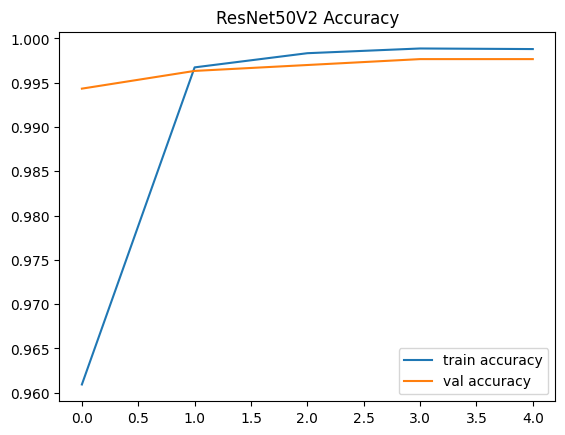

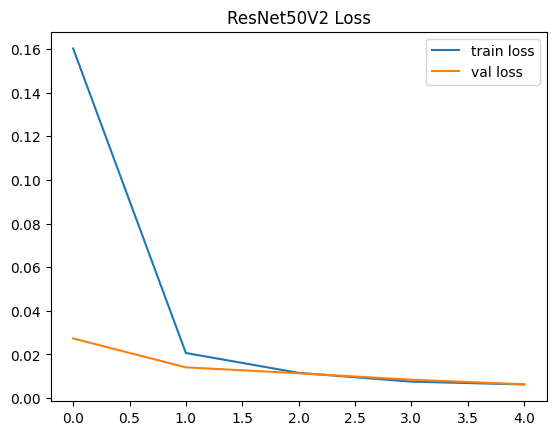

In [12]:
# ==========================================
# 4. PLOT & SAVE
# ==========================================
# Accuracy
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.title('ResNet50V2 Accuracy')
plt.savefig('ResNet_Acc.png')
plt.show()

# Loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.title('ResNet50V2 Loss')
plt.savefig('ResNet_Loss.png')
plt.show()

In [13]:
# Save Model (Using modern .keras format)
model.save('vegetable_resnet50v2.keras')
print("Model Saved.")

Model Saved.
